In [2]:
%reload_ext autoreload

In [3]:
%autoreload
from timegan_cnn import *
from utils import *


trainset = TimeGANDatasetSinus(num=32, seq_len=100, features=3)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3)
print(len(trainset))
print(trainset[0][0].size())

32
torch.Size([100, 3])


In [4]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn",
    tags=["test"],
    description="",
    source_files=["timegan_cnn.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "n_epochs": 10,
    "l_rate": 0.001,
    "batch_size": 32,
    "num_layers": 1,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params




model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

timegan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                )
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0), 100)

r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_z, 'pca')
run["PCA"].log(f_pca)
plt.close(f_pca)
f_tsne = visualization(r, gen_z, 'tsne')
run["tsne"].log(f_tsne)
plt.close(f_tsne)

run["mode_collapse"] = modeCollapseEvaluator(r, gen_z)


run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-12


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 9, Loss: 0.7720: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s]



Start Training with Supervised Loss Only


Epoch: 9, Loss: 0.1886: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s]



Start Joint Training


Epoch: 9, E: 1.8143, G: 7.4178, D: 2.0163: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Training Complete and Model Saved

Generating Data...Done
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.000s...
[t-SNE] Computed neighbors for 600 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.000010


/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.756516
[t-SNE] KL divergence after 300 iterations: 0.733267
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 39 operations to synchronize with Neptune. Do not kill this process.
All 39 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-12


In [23]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


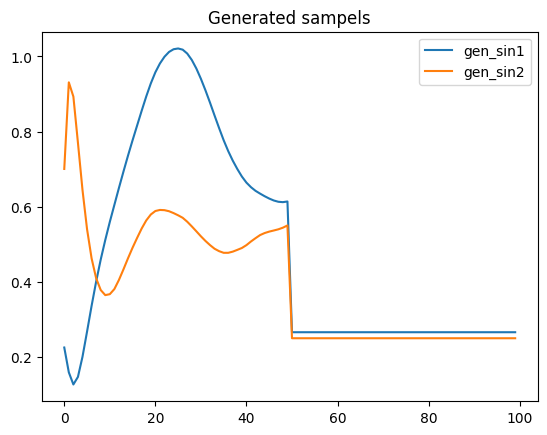

In [24]:
sample = 90
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
#plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [31]:
def printLayerShapes(model, input):
    for layer in layers:
        output = layer(input)
        print(f"{type(layer).__name__}: {list(input.size())} --> {list(output.size())}")
        input = output

In [32]:
input = torch.randn(20, 1, 100, 30)

## Discrininator
layers = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(1,3), stride=2, bias=True)
          #,nn.Flatten(start_dim=1)
          ,nn.Conv2d(in_channels=20, out_channels=40, kernel_size=(3,3), stride=2, bias=True)
          ,nn.Conv2d(in_channels=40, out_channels=80, kernel_size=(3,3), stride=2, bias=True)
          ,nn.Conv2d(in_channels=80, out_channels=100, kernel_size=(1,1), stride=2, bias=True)
          ,nn.Flatten(start_dim=1)
          ,nn.Linear(600, 1)
        )
printLayerShapes(layers, input)

Conv2d: [20, 1, 100, 30] --> [20, 20, 50, 14]
Conv2d: [20, 20, 50, 14] --> [20, 40, 24, 6]
Conv2d: [20, 40, 24, 6] --> [20, 80, 11, 2]
Conv2d: [20, 80, 11, 2] --> [20, 100, 6, 1]
Flatten: [20, 100, 6, 1] --> [20, 600]
Linear: [20, 600] --> [20, 1]


In [62]:
## Generator

input = torch.randn(20, 1, 100, 100)

layers = nn.Sequential(
     nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,3), stride=1, bias=True)
    ,nn.Conv2d(in_channels=20, out_channels=40, kernel_size=(3,3), stride=2, bias=True)
    ,nn.Conv2d(in_channels=40, out_channels=80, kernel_size=(3,3), stride=2, bias=True)
    ,nn.Conv2d(in_channels=80, out_channels=100, kernel_size=(1,1), stride=2, bias=True)
    ,nn.Flatten(start_dim=1)
    ,nn.Linear(14400, 3*100)
      #,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=16, stride=2, bias=True)
      #,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=12, stride=2, bias=True)
      #,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=6, stride=2, bias=True)
      #,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, bias=True)
      #,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, bias=True)
        )
printLayerShapes(layers, input)


Conv2d: [20, 1, 100, 100] --> [20, 20, 98, 98]
Conv2d: [20, 20, 98, 98] --> [20, 40, 48, 48]
Conv2d: [20, 40, 48, 48] --> [20, 80, 23, 23]
Conv2d: [20, 80, 23, 23] --> [20, 100, 12, 12]
Flatten: [20, 100, 12, 12] --> [20, 14400]
Linear: [20, 14400] --> [20, 300]


In [46]:
input[0,0][0]
nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1,1), stride=0, bias=True, padding_mode="zeros", padding=1)

Conv2d(1, 2, kernel_size=(1, 1), stride=(0, 0), padding=(1, 1))

In [132]:
output = layers[0](input)

In [79]:
class EmbeddingNetwork(nn.Module):

    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value, max_seq_len):
        super().__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        self.emb_rnn = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.emb_rnn2 = nn.Conv2d(in_channels=1,
                                  out_channels=16,
                                  kernel_size=3)


        self.emb_linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.emb_sigmoid = nn.Sigmoid()

        rnn_weight_init(self.emb_rnn)
        linear_weight_init(self.emb_linear)

    def forward(self, X, T):
        print("Input X:", X.size())
        X_packed = nn.utils.rnn.pack_padded_sequence(
            input=X,
            lengths=T,
            batch_first=True,
            enforce_sorted=False
        )

        H_o, H_t = self.emb_rnn(X_packed)

        H_o, T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )


        logits = self.emb_linear(H_o)
        H = self.emb_sigmoid(logits)
        return H

In [80]:


device = "cpu"
feature_dim = trainset[0][0].size(1)
model = EmbeddingNetwork(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=1,
                padding_value=0.,
                max_seq_len=trainset[0][0].size(0),
                )
model.to(device)

batch_size = 32
batched_data  = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True
    )

for X, T in batched_data:
    X = X.unsqueeze(1)
    pred = model.forward(X, T)
    print(pred.size())
    break


Input X: torch.Size([32, 1, 100, 3])


RuntimeError: input must have 2 dimensions, got 3